# Расчет показателей надежности восстанавливаемой системы с резервированием

In [1]:
# Импорт библиотек и настройка среды
%matplotlib inline
%precision 3

from matplotlib.pyplot import plot, xlabel, ylabel, title, grid, axhline, legend, show, ylim, xlim, rcParams, ticklabel_format
from numpy import matrix, linspace, ravel, vstack, vectorize
from scipy.integrate import odeint, quad
from scipy import interpolate
from IPython.display import Image
%config InlineBackend.figure_formats = ['svg']  #установить векторный формат для графиков

## Постановка задачи

Система состоит из двух восстанавливаемых аппаратов. Отказ системы наступает при одновременном отказе двух аппаратов.


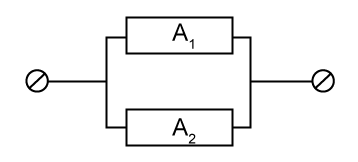

In [2]:
Image('pics/2app.png', embed=True)


Интенсивность отказов и восстановления аппаратов: $$\lambda_1 = 1,  \mu_1 = 2$$ $$\lambda_2 = 2, \mu_2 = 3$$


Требуется:
 - построить граф состояний системы
 - найти вероятности состояний
 - найти показатели надежности

В начальный момент времени система находится в исправном состоянии.

Потоки событий в системе - простейшие.

In [3]:
lambda1 = 1 #Интенсивность отказов
mu1 = 2 #Интенсивность восстановления

lambda2 = 2
mu2 = 3

## Математическая модель

### Граф состояний

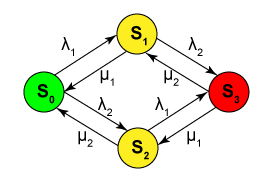

In [4]:
Image('pics/2app_graph.png', embed=True)


 - $S_0$ - оба аппарата исправны
 - $S_1$ - отказал аппарат 1
 - $S_2$ - отказал аппарат 2
 - $S_3$ - оба аппарата отказали, отказ системы


###Система уравнений Колмогорова
\begin{equation}
    \left\{
        \begin{aligned}
            \frac{dp_0(t)}{dt} & = -(\lambda_1 + \lambda_2) p_0(t) +  \mu_1 p_1(t)  + \mu_2 p_2(t) \\
            \frac{dp_1(t)}{dt} & = \lambda_1 p_0(t) - (\mu_1 + \lambda_2) p_1(t) + \mu_2 p_3(t)\\
            \frac{dp_2(t)}{dt} & = \lambda_2 p_0(t) - (\mu_2 + \lambda_1) p_2(t) + \mu_1 p_3(t)\\
            \frac{dp_3(t)}{dt} & =  \lambda_2 p_1(t)  + \lambda_1 p_2(t) -(\mu_1 + \mu_2) p_3(t)\\
        \end{aligned}
    \right.
\end{equation}

Начальные условия: $$ p_0(0)=1, p_1(0)=0, p_2(0) = 0, p_3(0) = 0 $$

In [5]:
#Начальные условия:
p0 = [1, 0, 0, 0]

#Правые части уравнений (вектор производных):
def dp_dt(p, t):
    dp0 = -(lambda1 + lambda2) * p[0] + mu1 * p[1] + mu2 * p[2]
    dp1 = lambda1 * p[0] - (mu1 + lambda2) * p[1] + mu2 * p[3]
    dp2 = lambda2 * p[0] - (mu2 + lambda1) * p[2] + mu1 * p[3]
    dp3 =  lambda2 * p[1] + lambda1 * p[2] -(mu1 + mu2) * p[3]
    return [dp0, dp1, dp2, dp3]

#Сетка для интегрирования
N = 200 #число шагов
tk = 4/lambda1 #конечный момент времени
t = linspace(0, tk, N+1)

#Решение системы
p = odeint(dp_dt, p0, t)

# Функция odeint выдает массив, элементами которого являются сечения случайного процесса 
# на заданный момент времени. Для построения графиков и расчета показателей надежности 
# удобнее работать с массивом, элементами которого являются все значения вероятности состояния 
# заданный момент времени. Такой массив можно получить с помощью транспонирования исходного.

p = p.T

Решение системы дифференциальных уравнений
См. также [справку](http://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.odeint.html#scipy.integrate.odeint) и [пример](http://docs.scipy.org/doc/scipy-0.14.0/reference/tutorial/integrate.html)

### Система уравнений Колмогорова для стационарного режима

\begin{equation}
    \left\{
        \begin{aligned}
            -(\lambda_1 + \lambda_2) P_0 +  \mu_1 P_1  + \mu_2 P_2 & = 0 \\
            \lambda_1 P_0 - (\mu_1 + \lambda_2) P_1 + \mu_2 P_3 & = 0\\
            \lambda_2 P_0 - (\mu_2 + \lambda_1) P_2 + \mu_1 P_3 & = 0\\
            P_0 + P_1 + P_2 + P_3 & = 1\\
        \end{aligned}
    \right.
\end{equation}

Предельные вероятности состояний можно найти, решив систему линейных уравнений для стационарного режима

In [6]:
A = matrix([[-(lambda1 + lambda2), mu1, mu2, 0],
            [lambda1, -(mu1 + lambda2), 0, mu2],
            [lambda2, 0, -(mu2 + lambda1), mu1],
            [1, 1, 1, 1]]
           )

B = matrix([[0],
            [0],
            [0],
            [1]])

P = A.I * B

# В результате решения системы получается вектор-столбец - матрица с 2 строками и 1 столбцом
# здесь она преобразуется в одномерный массив для упрощения индексации
P = ravel(P) 

print('Предельные вероятности состояний: P = ', P)

Предельные вероятности состояний: P =  [0.4   0.2   0.267 0.133]


### Вероятности состояний

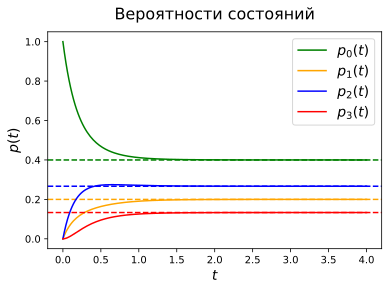

In [7]:
#График

colors = ['green', 'orange', 'blue', 'red']

for i in range(p.shape[0]):
    plot(t, p[i], label = '$p_%s(t)$' %i, color = colors[i])
    axhline(y=P[i], linestyle='--', color = colors[i]) #предельные вероятности
    
legend(loc='best', fontsize=14) #легенда
#grid() #сетка

xlabel('$t$', fontsize=14) #подписи для осей и графика
ylabel('$p(t)$', fontsize=14)
title(u'Вероятности состояний', fontsize=16, y=1.03);


### Функции, интерполирующие вероятности состояний

Решение системы уравнений численным методом дает таблицу значений вероятностей состояний в дискретных точках

Для удобства работы можно преобразовать эти дискретные данные в непрерывные функции, определенные на интервале $\left[ 0, t_k \right]$

[Примеры интерполяции данных](http://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html)

In [8]:
# Используется сплайновая интерполяция
p_int = [interpolate.InterpolatedUnivariateSpline(t, y) for y in p]
#полученные функции определены на интервале [0, tk]

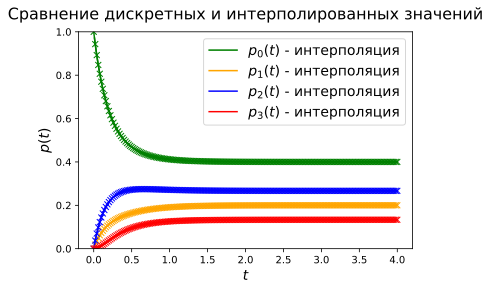

In [9]:
# Сравнение дискретных и интерполированных значений вероятностей
tnew = linspace(tk/(2*N), tk, 2*N)

for i in range(p.shape[0]):
    plot(tnew, p_int[i](tnew), color=colors[i], label='$p_%s(t)$ - интерполяция'%i)
    plot(t, p[i], color=colors[i], marker='x')

legend(loc='upper right',fontsize=14) #легенда
#grid()
ylim([0,1])
#xlim([0,500])

xlabel('$t$', fontsize=14) #подписи для осей и графика
ylabel('$p(t)$', fontsize=14)
title(u'Сравнение дискретных и интерполированных значений', size=16, y=1.03);

## Расчет показателей надежности

### Коэффициент готовности

Стационарный коэффициент готовности:

$$К_Г = \sum_{s \in U} P_s, $$

где $U$ - множество работоспособных состояний


Функция готовности:

$$К_Г(t) = \sum_{s \in U} p_s(t), $$ где $U$ - множество работоспособных состояний

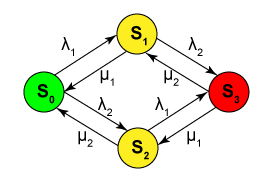

In [10]:
Image('pics/2app_graph.png', embed=True)

In [11]:
# Стационарный коэффициент готовности:
K_G = P[0] + P[1] + P[2]
print('Стационарный коэффициент готовности: %.2f'% K_G)

# Функция готовности:
def G(t):    
    return p_int[0](t) + p_int[1](t) + p_int[2](t) #сумма вероятностей работоспособных и частично работоспособных состояний



Стационарный коэффициент готовности: 0.87


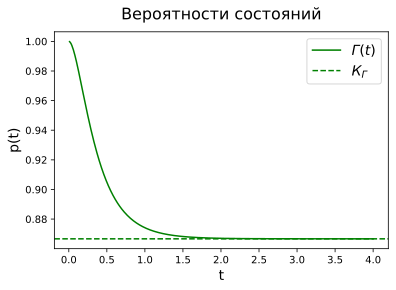

In [12]:
#График
plot(tnew,G(tnew),'g-',label = r'$Г(t)$') #Функция готовности
axhline(y=K_G, linestyle='--', color='green', label=r'$К_Г$') #Стационарный коэффициент готовности

legend(loc='best', fontsize=14) #легенда

xlabel('t', size=14) #подписи для осей и графика
ylabel(r'p(t)', size=14)
title(u'Вероятности состояний', size=16, y=1.03);

### Параметр потока отказов

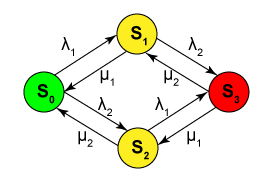

In [13]:
Image('pics/2app_graph.png', embed=True)

Стационарный параметр потока отказов:  $ \omega_f = \lambda_2 P_1 + \lambda_1 P_2$

Параметр потока отказов: $ \omega(t) = \lambda_2 p_1(t) + \lambda_1 p_2(t) $

In [14]:
# Стационарный параметр потока отказов:
omega_f = lambda2 * P[1] + lambda1 * P[2]

print('Стационарный параметр потока отказов: %.2f'% omega_f)

# Параметр потока отказов:
def omega(t):
    return lambda2 * p_int[1](t)  + lambda1 * p_int[2](t)

Стационарный параметр потока отказов: 0.67


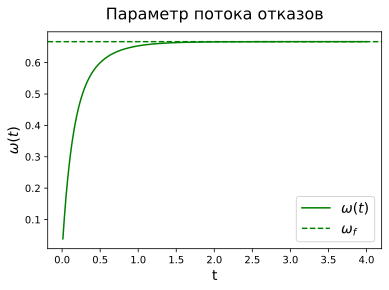

In [15]:
#График
plot(tnew,omega(tnew),'g-',label = r'$\omega(t)$') # Параметр потока отказов
axhline(y=omega_f, linestyle='--', color='green', label=r'$\omega_f$') #Стационарный параметр потока отказов

legend(loc='best', fontsize=14) #легенда

xlabel('t', size=14) #подписи для осей и графика
ylabel(r'$\omega(t)$', size=14)
title(u'Параметр потока отказов', size=16, y=1.03);

### Ведущая функция потока отказов

$$\Omega(t)=\int_{0}^t\omega(\tau)d\tau$$

In [16]:
# Ведущая функция потока отказов
def Omega(t):
    return quad(omega,0,t)[0]

### Средняя наработка на отказ

Предельное значение (в стационарном режиме):
    
$$ \bar{t_f} = \frac{К_Г}{w_f} $$

Средняя наработка на отказ:

$$ \bar{t}(t) = \frac{\int_0^t Г(\tau)d\tau}{\Omega(t)} $$

In [17]:
# Предельное значение средней наработки на отказ
t_avg_f = K_G / omega_f
print('Предельное значение средней наработки на отказ: %.2f'% t_avg_f)

# Средняя наработка на отказ
def intG(t):
    return quad(G, 0, t)[0]

@vectorize
def t_avg(t):
    return  intG(t) / Omega(t)



Предельное значение средней наработки на отказ: 1.30


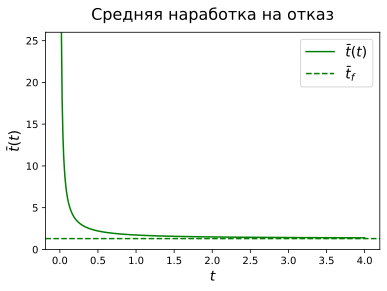

In [18]:
#График
plot(tnew,t_avg(tnew),'g-',label = r'$\bar{t}(t)$') # Средняя наработка на отказ
axhline(y=t_avg_f, linestyle='--', color='green', label=r'$\bar{t}_f$') #Стационарное значение средней наработки на отказ

#ticklabel_format(style='plain', axis='y')
legend(loc='best', fontsize=14) #легенда
#grid() #сетка

xlabel('$t$', size=14) #подписи для осей и графика
ylabel(r'$\bar{t}(t)$', size=14)
ylim(0, 20 * t_avg_f)
title('Средняя наработка на отказ', size=16, y=1.03);